# NASCAR_analysis_ohbm

In [1]:
from scipy.io import loadmat
import numpy as np
import hcp_utils as hcp
import nilearn.plotting as plotting

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set("paper", "white")
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

from analysis import plot_results

import npp
#from sklearn.preprocessing import minmax_scale

import seaborn as sns
from scipy.stats import ttest_ind

import utility
import npp

from hrf_tools import apply_optimal_hrf_10hz

/opt/miniconda-latest/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


### Load the data from matlab

In [2]:
outputs_file='/om2/scratch/Fri/jsmentch/nascar_data/output/results_TP_clean.mat'
#mat_contents = loadmat(outputs_file, squeeze_me=True, simplify_cells = True)
mat_contents = loadmat(outputs_file)
rank=19
components=mat_contents['result']['U'][0,rank][0,0]
temporal_modes=mat_contents['result']['U'][0,rank][1,0]
contributions=mat_contents['result']['U'][0,rank][2,0]

meta_file='/om2/scratch/Fri/jsmentch/nascar_data/input/movieTP_meta.mat'
mat_contents = loadmat(meta_file)
dx_list=mat_contents['dx_list'].squeeze()
sub_list=mat_contents['sub_list']
ses_list=mat_contents['ses_list']


### look into the contributions from each subject by group

In [57]:
asc_ind=np.nonzero(dx_list)[0]
td_ind=np.where(dx_list == 0)[0]
t_list=[]
p_list=[]
for i in np.arange( contributions.shape[1] ):
    asc_contributions = contributions[:,i][asc_ind]
    td_contributions = contributions[:,i][td_ind]
    t,p=ttest_ind(asc_contributions, td_contributions)
    t_list.append(t)
    p_list.append(p)

In [ ]:
dx_list_string=[]
for d in dx_list:
    dx_list_string.append( ['TD','ASC'][d] )
column_list=[]
for i in np.arange(20):
    column_list.append(f'component{i+1}')
    
df = pd.DataFrame(contributions, columns=column_list)
df.insert(0, "dx", dx_list_string, True)
df.insert(0, "ses", ses_list, True)
df.insert(0, "sub", sub_list, True)
df=pd.melt(df, id_vars=['sub','ses','dx'], value_vars=column_list, var_name='component', value_name='contribution')

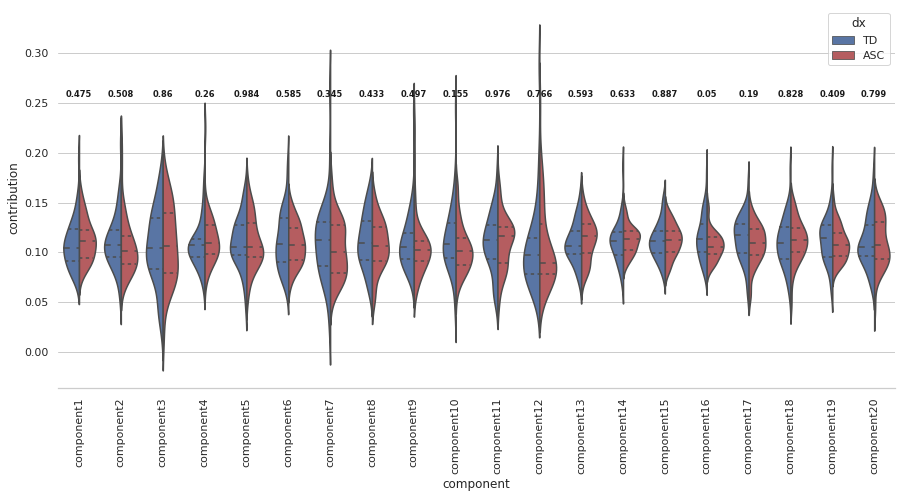

In [136]:
plt.figure(figsize=(15,7))

sns.set_theme(style="whitegrid")
#sns.set(font_scale=2)
# Draw a nested violinplot and split the violins for easier comparison
violinplot=sns.violinplot(data=df, x="component", y="contribution", hue="dx",
               split=True, inner="quart", linewidth=1.5, palette={"TD": "b", "ASC": "r"})
sns.despine(left=True)
plt.xticks(rotation=90)


#p_values = df.groupby(['component'])['contribution'].median()
vertical_offset = df['contribution'].median() * 0.05 # offset from median for display

for xtick in violinplot.get_xticks():
    violinplot.text(xtick,0.25 + vertical_offset, round(p_list[xtick],3), 
            horizontalalignment='center',size='x-small',color='k',weight='semibold')

### look into the timecourses now

In [3]:
#temporal_modes=mat_contents['result']['U'][0,rank][1,0]
temporal_modes.shape

(250, 20)

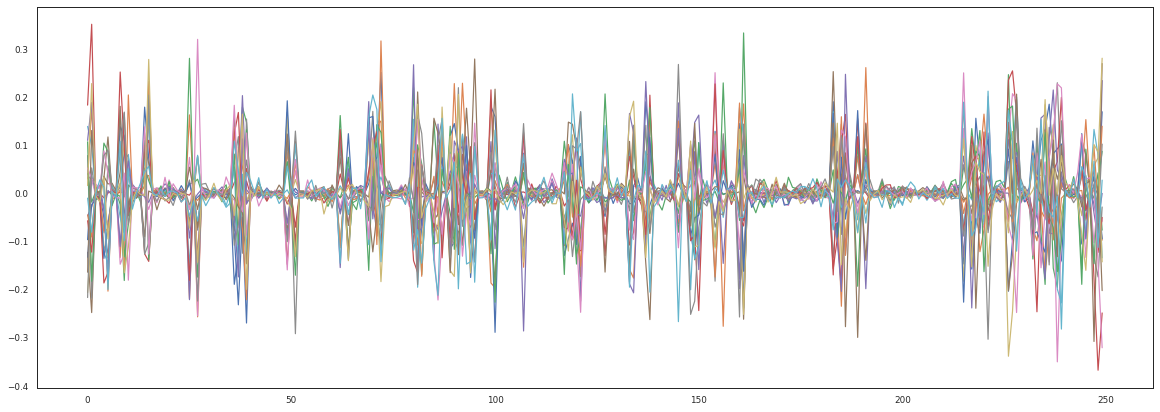

In [8]:
plt.figure(figsize=(20,7))
for t in np.arange(20):
    #plt.figure(figsize=(20,7))
    plt.plot(temporal_modes[:,t])

### load features
load features into 'features' list and their names into 'class_names' list

In [34]:
features=[]
feature_names=[]
feature_dir='/om2/scratch/Fri/jsmentch/nat_img/sourcedata/data/HBN/features/'

#load YAMNET audioset features
class_names, as_classes_label, as_classes, labels = utility.load_yamnet_info()
class_names=list(class_names)
as_scores=np.load(f'{feature_dir}TP_as_scores.npy')
as_scores=apply_optimal_hrf_10hz(as_scores,2)

#get top 5 audioset features and print them
means=np.mean(as_scores, axis=0)
for l in list (means.argsort()[-5:][::-1] ):
    print(class_names[l])
    features.append( npp.zs(utility.downsample(as_scores[:,l],250)) )
    feature_names.append(class_names[l])

#load more features
#for f in ['optic_flow','brightness','frac_high_saliency','max_saliency','vibrance']:
for f in ['optic_flow','brightness','frac_high_saliency','vibrance']:
    loaded_f=np.load(f'{feature_dir}TP_{f}_10hz.npy')
#     plt.figure(figsize=(20,7))
#     plt.plot(loaded_f)
#     print(np.asanyarray(loaded_f)[np.newaxis,:].shape)
    loaded_f=apply_optimal_hrf_10hz( np.asanyarray(loaded_f)[:,np.newaxis] ,10)
#     plt.figure(figsize=(20,7))
#     plt.plot(loaded_f)
    loaded_f=utility.downsample(list(loaded_f.squeeze()),250)
#     plt.figure(figsize=(20,7))
#     plt.plot(loaded_f)
#     plt.figure(figsize=(20,7))
#     plt.plot(npp.zs(loaded_f) )
    features.append( npp.zs(loaded_f) )
    feature_names.append(f)
    
print('feature_names ', feature_names)
print('len(features) ', len(features) )


Music
Speech
Animal
Vehicle
Dog
feature_names  ['Music', 'Speech', 'Animal', 'Vehicle', 'Dog', 'optic_flow', 'brightness', 'frac_high_saliency', 'vibrance']
len(features)  9


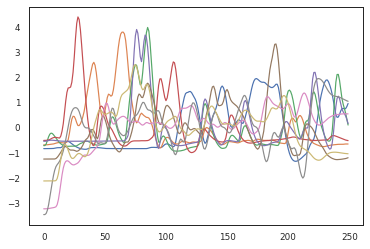

In [30]:
for f in features:
    plt.plot(f)

Text(0.5, 0, 'TR')

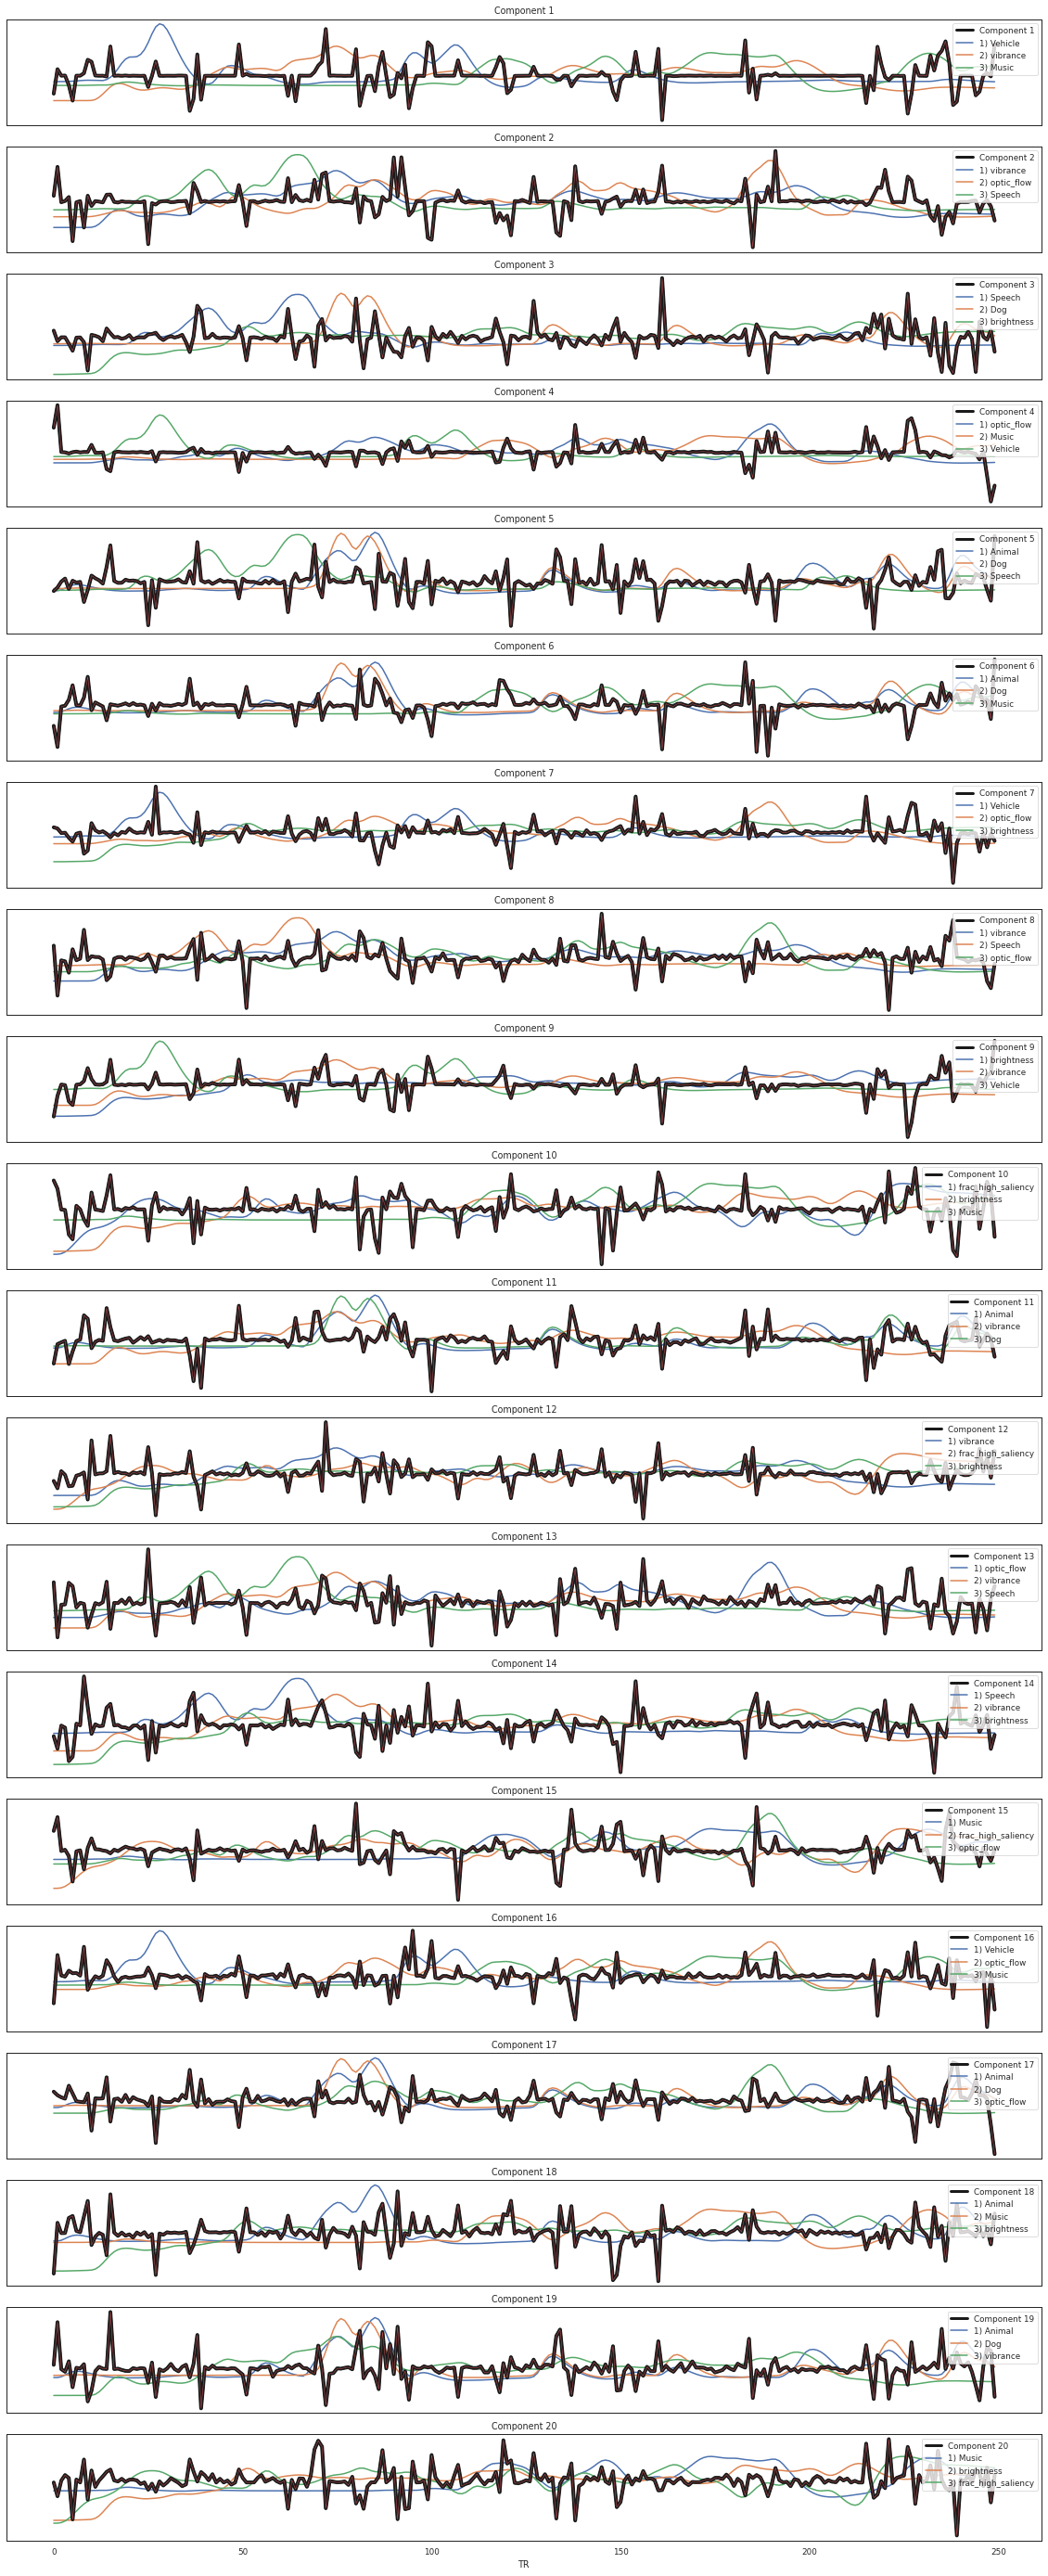

In [81]:
corr_list_list=[]
for t in np.arange(20):
    corr_list=[]
    current_t=npp.zs(temporal_modes[:,t])
    for f in features:
        corr_list.append( np.correlate(f, current_t )[0] )
    corr_list_list.append(corr_list)
corr_list_list=np.asanyarray(corr_list_list)

# top_corr=[]
# top_corr_ind=[]
# for corr_list in corr_list_list:
#     top_corr.append(  feature_names [np.asanyarray(corr_list).argmax()]  )
#     top_corr_ind.append(np.asanyarray(corr_list).argmax())


# axs[0].scatter(nt_list,np.random.random(nt_list.shape),15,label=nt_label,c='g',alpha=0.5)
# axs[0].scatter(adhd_list,np.random.random(adhd_list.shape),15,label=adhd_label,c='b',alpha=0.5)
# axs[0].scatter(depression_list,np.random.random(depression_list.shape),15,label=depression_label,c='r',alpha=0.5)
# axs[0].scatter(asd_list,np.random.random(asd_list.shape),15,label=asd_label,c='m',alpha=0.5)
# axs[0].set_yticklabels([])
# axs[0].legend()
# axs[0].set_xlim(0,0.5)



fig, axs = plt.subplots( len(corr_list_list), 1, figsize=(20,50),sharex=True,squeeze=True)
#fig.suptitle('HBN TITLE')
for t,corr_list in enumerate(corr_list_list):
#     axs[0].figure(figsize=(20,7))
    axs[t].plot( npp.zs(temporal_modes[:,t]) ,label=f'Component {t+1}', color='k', linewidth=3)

    for i,top in enumerate( corr_list.argsort()[-3:][::-1] ):
        axs[t].plot( features[top], label=f'{i+1}) {feature_names[top]}', linewidth=1.5)
    axs[t].legend(loc='upper right')
    axs[t].plot( npp.zs(temporal_modes[:,t]) ,label=f'Component {t+1}', color='k', linewidth=4)
    axs[t].plot( npp.zs(temporal_modes[:,t]) ,label=f'Component {t+1}', color='r', linewidth=0.5)
    axs[t].title.set_text(f'Component {t+1}')
    axs[t].set_yticklabels([])
axs[t].set_xlabel('TR')